# Loading the data

In [1]:
import numpy as np

In [2]:
dataset = np.load("./1.npy")

In [3]:
dataset.shape

(259520, 65)

In [4]:
dataset = dataset[dataset[:,-1]!=10,:]

# Convert your dataset into `segments`

In [5]:
def extract(input, n_classes, n_fea, time_window, moving):
    xx = input[:, :n_fea]
    yy = input[:, n_fea:n_fea + 1]
    new_x = []
    new_y = []
    number = int((xx.shape[0] / moving) - 1)
    for i in range(number):
        ave_y = np.average(yy[int(i * moving):int(i * moving + time_window)])
        if ave_y in range(n_classes + 1):
            new_x.append(xx[int(i * moving):int(i * moving + time_window), :])
            new_y.append(ave_y)

    new_x = np.array(new_x)
    new_x = new_x.reshape([-1, n_fea * time_window])
    new_y = np.array(new_y)
    new_y.shape = [new_y.shape[0], 1]
    data = np.hstack((new_x, new_y))
    data = np.vstack((data, data[-1]))  # add the last sample again, to make the sample number round
    return data

In [6]:
data = extract(dataset ,10 ,64 ,16 ,8)

# How to Divide Data into Training and Testing Sets

In [7]:
from sklearn.model_selection import train_test_split
n_fea = 64
time_window = 16
no_longfeature = n_fea * time_window
data_seg_feature = data[:, :no_longfeature]
data_seg_label = data[:, no_longfeature:no_longfeature+1]
train_feature, test_feature, train_label, test_label = train_test_split(data_seg_feature, data_seg_label,test_size=0.2, shuffle=True)

In [8]:
train_feature.shape

(13754, 1024)

In [9]:
test_feature.shape

(3439, 1024)

# Data Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler().fit(train_feature)
train_fea_norm1 = scaler1.transform(train_feature) # normalize the training data
test_fea_norm1 = scaler1.transform(test_feature) # normalize the test data

# Building a CNN Network

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=(2,4),
                stride=1,
                padding= (1,2)  #([1,2]-1)/2,
            ),
            nn.ReLU(),
            nn.MaxPool2d((2,4))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, (2,2), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )


        self.fc = nn.Linear(1024, 128)  # 64*2*4
        self.out = nn.Linear(128, n_class)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        x = F.dropout(x, p=0.2)
        output = self.out(x)
        return output

In [13]:
BATCH_size = 100
n_class = 10

# Training your CNN Network

In [14]:
n_class=10
cnn = CNN()
# let's pass an input to it
input = torch.randn(BATCH_size, 1, 16, 64)
output = cnn(input)

In [15]:
cnn = CNN()
# lets test out network by passing noise to it  as input
import time
start_time = time.perf_counter()




device = "cuda" if torch.cuda.is_available() else "cpu"
cnn.to(device)
LR = 0.001
l2 = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR, weight_decay=l2)
loss_func = nn.CrossEntropyLoss()

In [16]:
segment_length = 16
no_feature = 64

train_fea_norm1 = train_fea_norm1.reshape([-1, segment_length, no_feature])
test_fea_norm1 = test_fea_norm1.reshape([-1, segment_length, no_feature])

In [17]:
train_label.shape

(13754, 1)

In [18]:
BATCH_size = 10000

In [19]:
import torch.utils.data as Data

# feed data into dataloader
train_fea_norm1 = torch.tensor(train_fea_norm1)
train_fea_norm1 = torch.unsqueeze(train_fea_norm1, dim=1).type('torch.FloatTensor').to(device)

train_label = torch.tensor(train_label.flatten()).to(device)
train_data = Data.TensorDataset(train_fea_norm1, train_label)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_size, shuffle=True)

test_fea_norm1 = torch.tensor(test_fea_norm1)
test_fea_norm1 = torch.unsqueeze(test_fea_norm1, dim=1).type('torch.FloatTensor').to(device)
test_label = torch.tensor(test_label.flatten()).to(device)

In [20]:
# training and testing
for epoch in range(300):
    for step, (train_x, train_y) in enumerate(train_loader):
        output = cnn(train_x)  # CNN output of training data
        loss = loss_func(output, train_y.long())  # cross entropy loss
        optimizer.zero_grad()  # clear gradients for this training step
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients

    if epoch % 10 == 0:
        test_output = cnn(test_fea_norm1)  # CNN output of test data
        test_loss = loss_func(test_output, test_label.long())

        print(test_loss.item())

2.2793755531311035
2.1681714057922363
2.0714128017425537
2.0080549716949463
1.9775153398513794
1.9409970045089722
1.9183886051177979
1.8880029916763306
1.8676626682281494
1.8488284349441528
1.8297595977783203
1.8214794397354126
1.8213618993759155
1.7913509607315063
1.7837984561920166
1.7708264589309692
1.7855652570724487
1.7581967115402222
1.7578779458999634
1.7284642457962036
1.727992296218872
1.7037415504455566
1.7372355461120605
1.692492127418518
1.686528205871582
1.6793272495269775
1.6790112257003784
1.6697803735733032
1.6510930061340332
1.647756814956665


Confusion Matrix:
[[ 58   1  24  23  24  27  16   8  25  19]
 [  3 191   3   4   6   9   4   4   5   7]
 [ 23   4 131  57  18  48  33  22  28  17]
 [ 21   7  39 151  12  27  43  20  27  11]
 [ 18   9  19  15 135  68  15  10  38  31]
 [  7   3  16  22  57 153  31  15  33  25]
 [  8   5  22  26  19  28 176  42  58  31]
 [  8   1  20  28  10  25  63 160  22  31]
 [  9   6  19   9  30  31  40  15 133  44]
 [  7   9  22  17  28  37  26  33  67 154]]


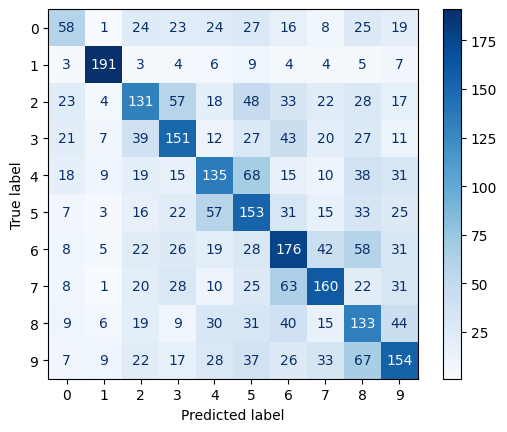

In [21]:
from sklearn.metrics import  confusion_matrix ,ConfusionMatrixDisplay

true_y = test_label.data.cpu().numpy()
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy()

# Create confusion matrix
conf_matrix = confusion_matrix(true_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')